In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
import os
import matplotlib.colors as colors

In [2]:
# ran on AWS g6.xlarge EC2
if torch.cuda.is_available():
    print(f'CUDA is available! Device name: {torch.cuda.get_device_name(0)}')

CUDA is available! Device name: NVIDIA L4


In [4]:
image_width, image_height = 224, 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_height, image_width)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_height, image_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

class JPGImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.imgs = [(p, c) for p, c in self.imgs if p.lower().endswith('.jpg') and '.ipynb' not in p]
        self.samples = self.imgs

    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and '.ipynb' not in d]
        classes.sort()
        return classes, {cls_name: i for i, cls_name in enumerate(classes)}

data_dir = 'images'

image_datasets = {
    'train': JPGImageFolder(root=os.path.join(data_dir, 'train'), transform=data_transforms['train']),
    'test': JPGImageFolder(root=os.path.join(data_dir, 'test'), transform=data_transforms['test'])
}

batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

class_names = image_datasets['train'].classes
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


#### FourLayer CNN

In [6]:
class FourLayer(nn.Module):

    CONV1 = 64
    CONV2 = 128
    CONV3 = 256
    CONV4 = 512
    FC1 = 1024
    OUTPUT_DIM = 512

    def __init__(self, num_classes, batch_size, image_height, image_width):
        super(FourLayer, self).__init__()
        
        self.conv1 = nn.Conv2d(3, self.CONV1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.CONV1)
        self.conv2 = nn.Conv2d(self.CONV1, self.CONV2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(self.CONV2)
        
        self.conv3 = nn.Conv2d(self.CONV2, self.CONV3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(self.CONV3)
        self.conv4 = nn.Conv2d(self.CONV3, self.CONV4, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(self.CONV4)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        flattened_size = (image_height // 16) * (image_width // 16) * self.CONV4
        self.fc1 = nn.Linear(flattened_size, self.FC1)
        self.fc2 = nn.Linear(self.FC1, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### Training

In [ ]:
model = FourLayer(
    num_classes=len(class_names),
    batch_size=batch_size,
    image_height=image_height,
    image_width=image_width
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_loader = dataloaders['train']
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} - Loss: {0.0:.4f} - Acc: {0.0:.4f}')
    
    batch_times = []
    for batch_idx, (inputs, labels) in enumerate(pbar):
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = correct / total
        pbar.set_description(f'Epoch {epoch+1} - Loss: {loss.item():.4f} - Acc: {accuracy:.4f}')
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    
    print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
    
    model.eval()
    
    test_loader = dataloaders['test']
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

model_name = 'skin-cancer-recognition.pth'
torch.save(model, model_name)
print(f'Model saved as {model_name}')
print('Training complete')

#### Grad-CAM

In [10]:
def grad_cam(image_id, img_path, lesion_type):

    model = torch.load('skin-cancer-recognition.pth', weights_only=False, map_location=device)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (image_width, image_height))
    img_original = img.copy()

    img = img / 255.0
    img = img - np.array([0.5, 0.5, 0.5])
    img = img / np.array([0.5, 0.5, 0.5])
    img = np.transpose(img, (2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float().to(device)

    model.eval()

    features = []
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())

    last_layer = None
    for child in model.modules():
        if isinstance(child, nn.Conv2d):
            last_layer = child
            
    if last_layer is not None:
        handle = last_layer.register_forward_hook(hook)
    output = model(img)
    handle.remove()

    feature_maps = features[0]
    weights = model.fc2.weight.detach().cpu().numpy()
    predicted_class = output.argmax().item()
    cam = np.zeros((feature_maps.shape[2], feature_maps.shape[3]))

    for i in range(feature_maps.shape[1]):
        cam += feature_maps[0, i, :, :] * weights[predicted_class, i]

    
    cam = cv2.resize(cam, (image_width, image_height))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    threshold = 0.5
    cam[cam < threshold] = 0

    kernel_size = (5, 5)
    sigma = 1.0
    cam_smooth = cv2.GaussianBlur(cam, kernel_size, sigma)

    plt.figure(figsize=(15, 5), dpi=300)
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    plt.title(f'Original\n{lesion_type} - 00{image_id}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    plt.imshow(cam_smooth, cmap=cm.jet, alpha=0.35)
    plt.title(f'Grad-CAM\n{lesion_type} - 00{image_id}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.zeros((1, 1)), cmap=cm.jet)
    plt.gca().set_visible(False)

    norm = colors.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=1)
    cbar.set_ticks([0.0, 1.0])
    cbar.set_ticklabels(['0.0', '1.0'])
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')

    plt.tight_layout()
    plt.show()

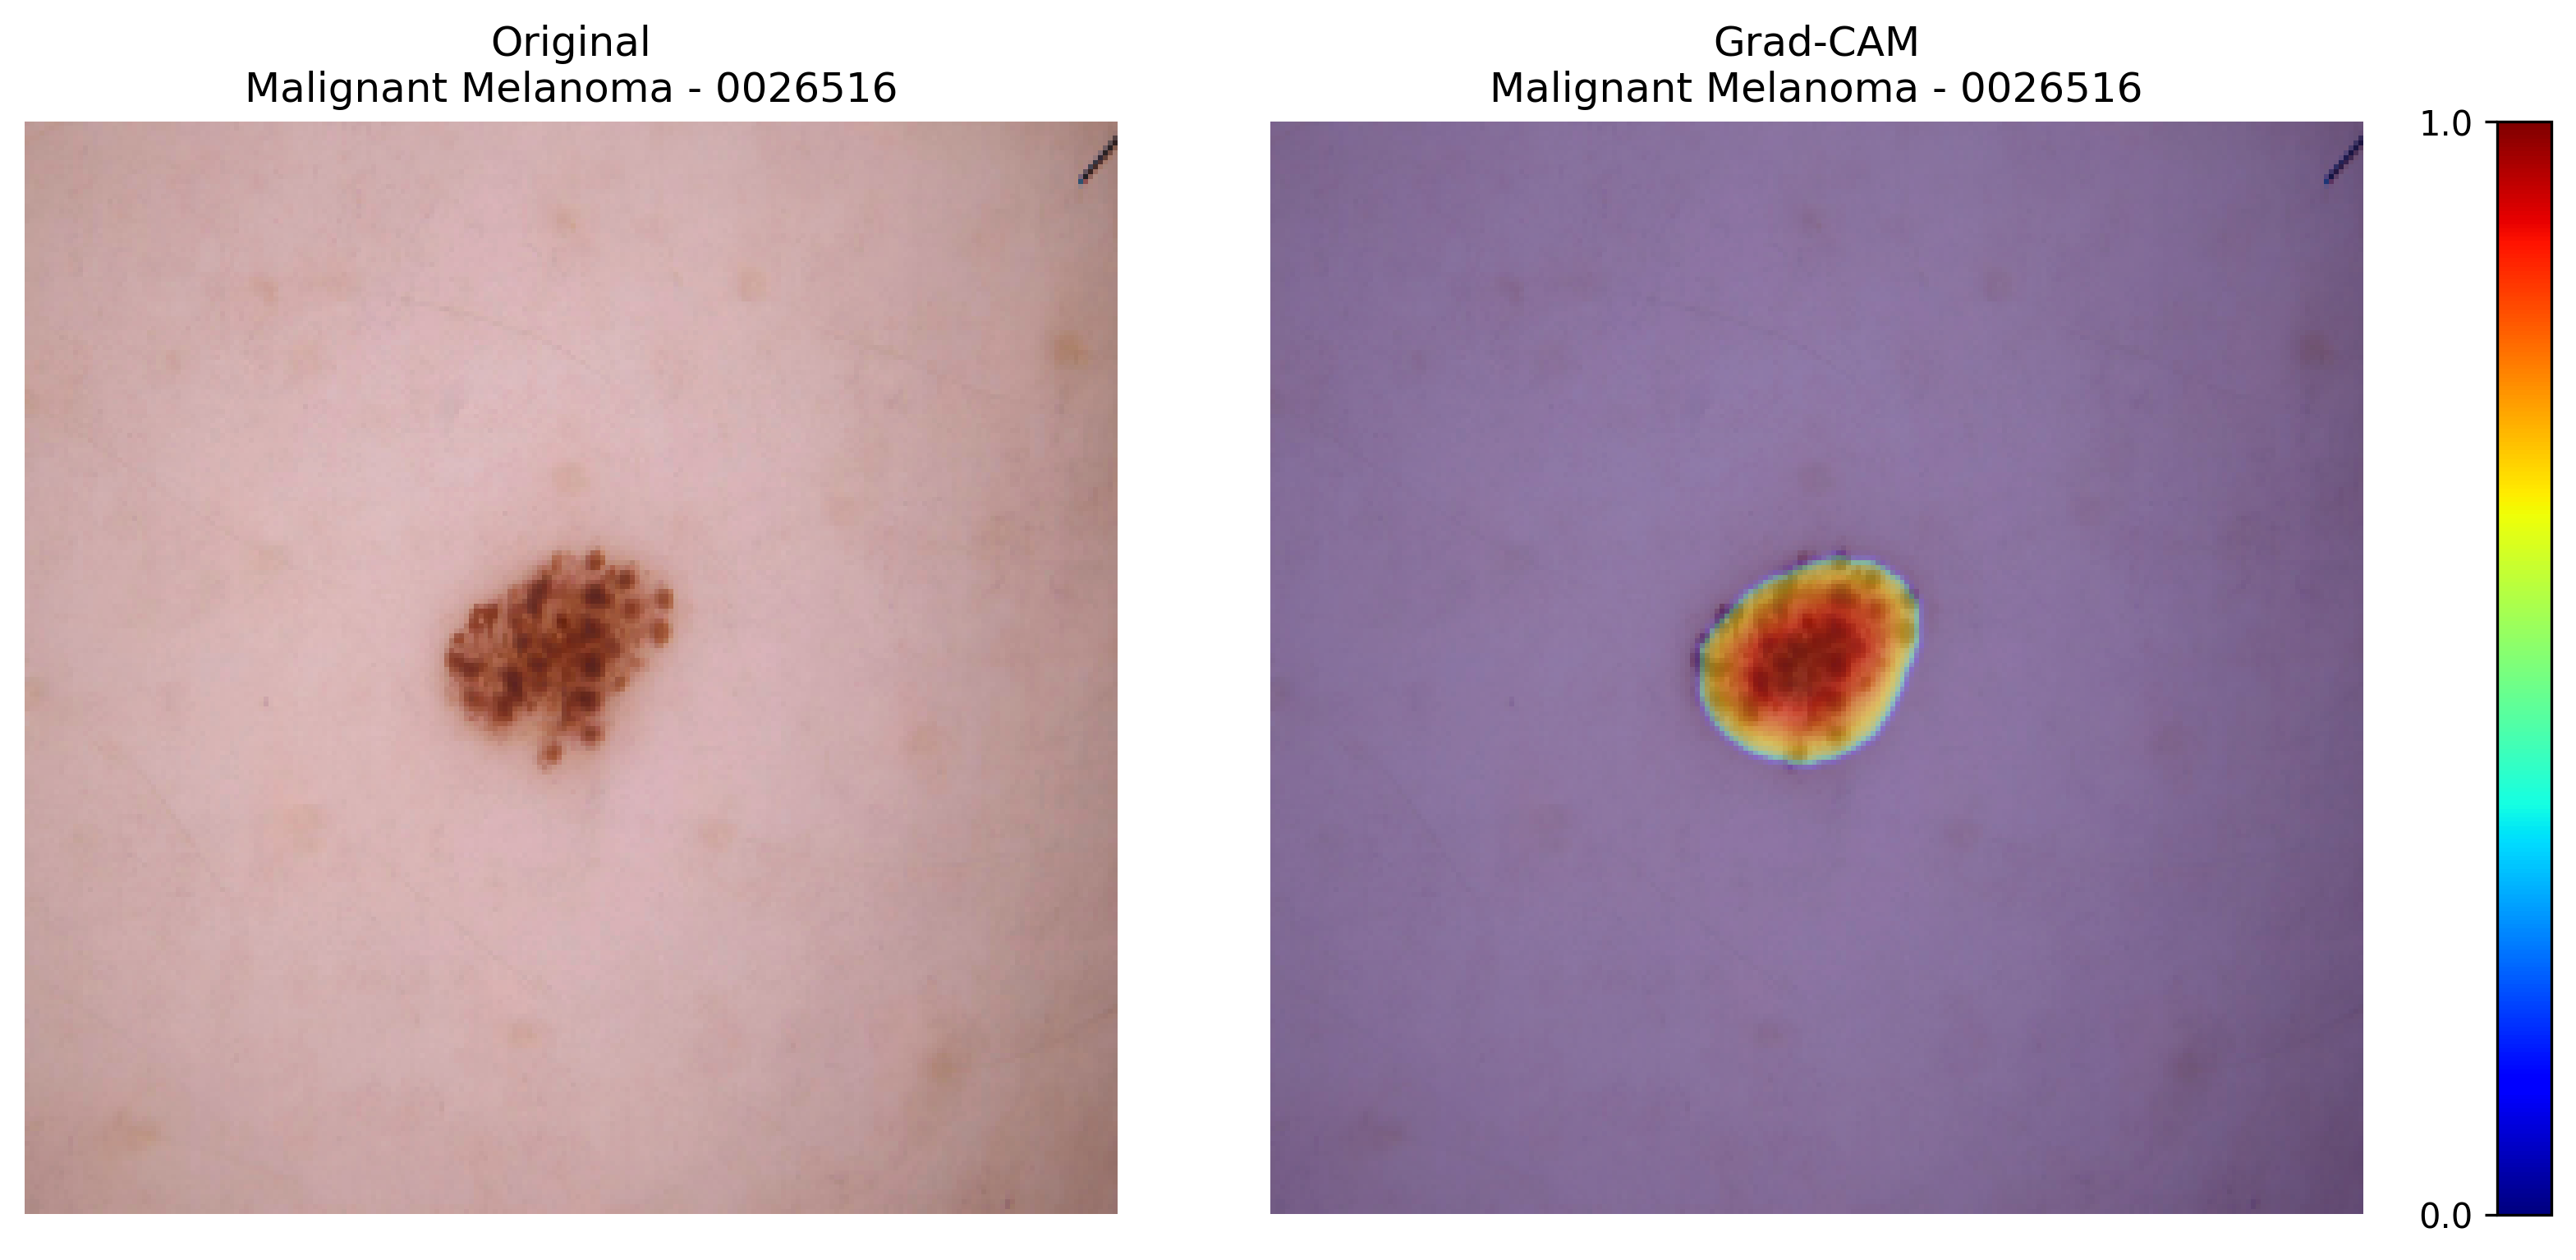

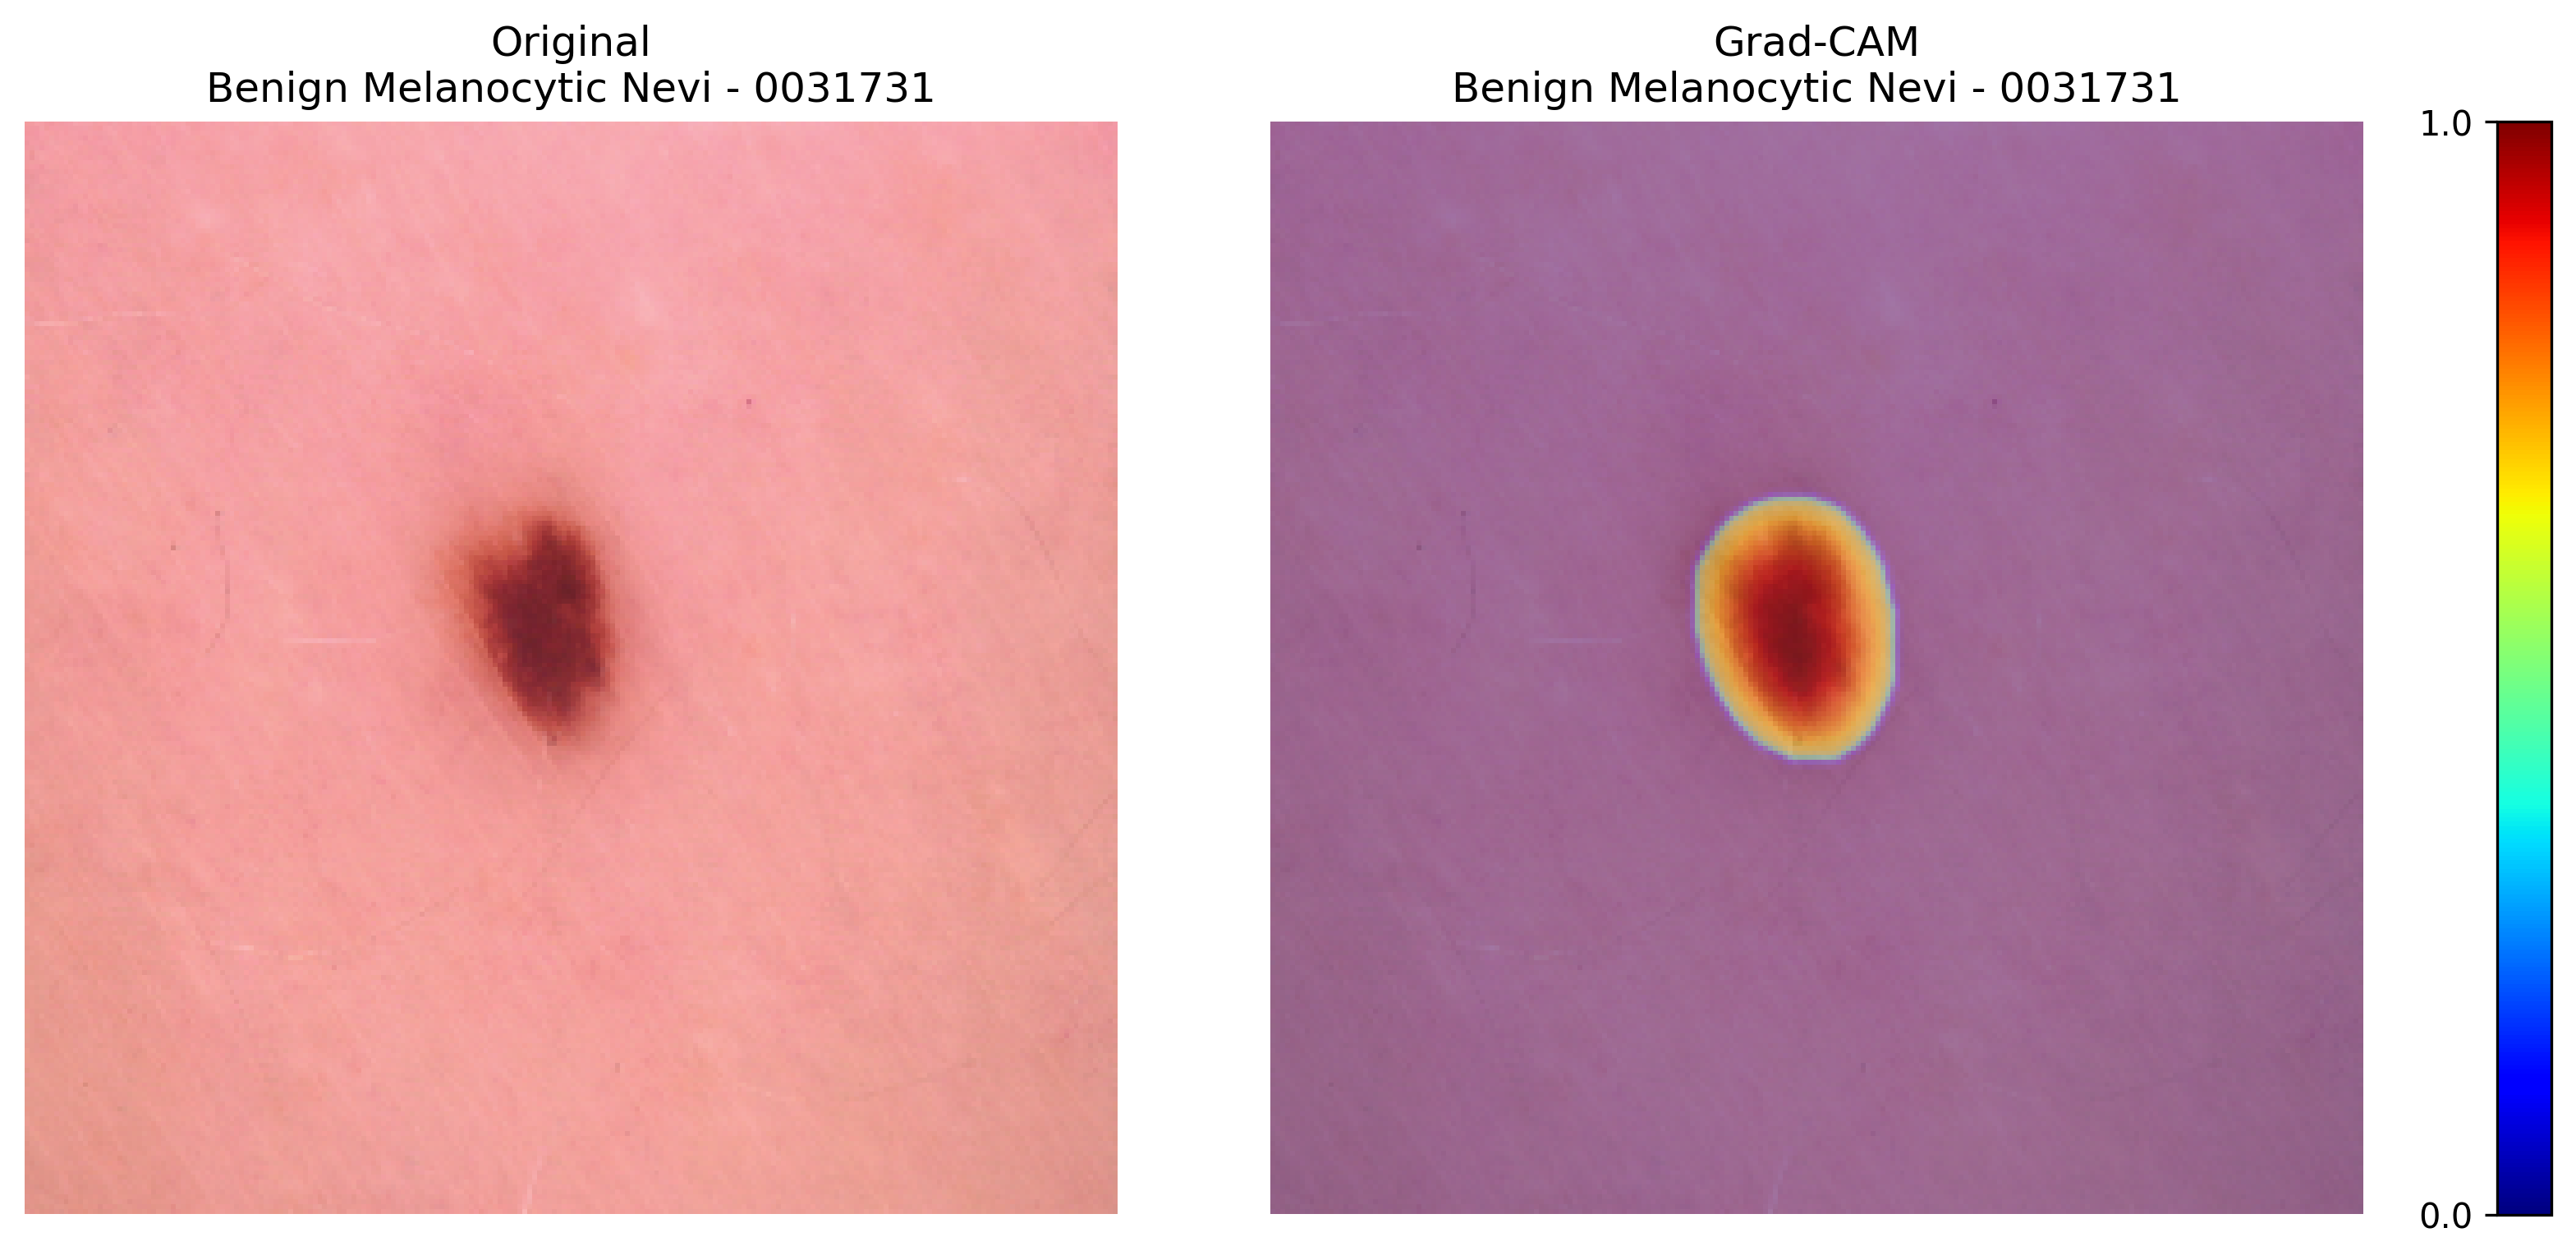

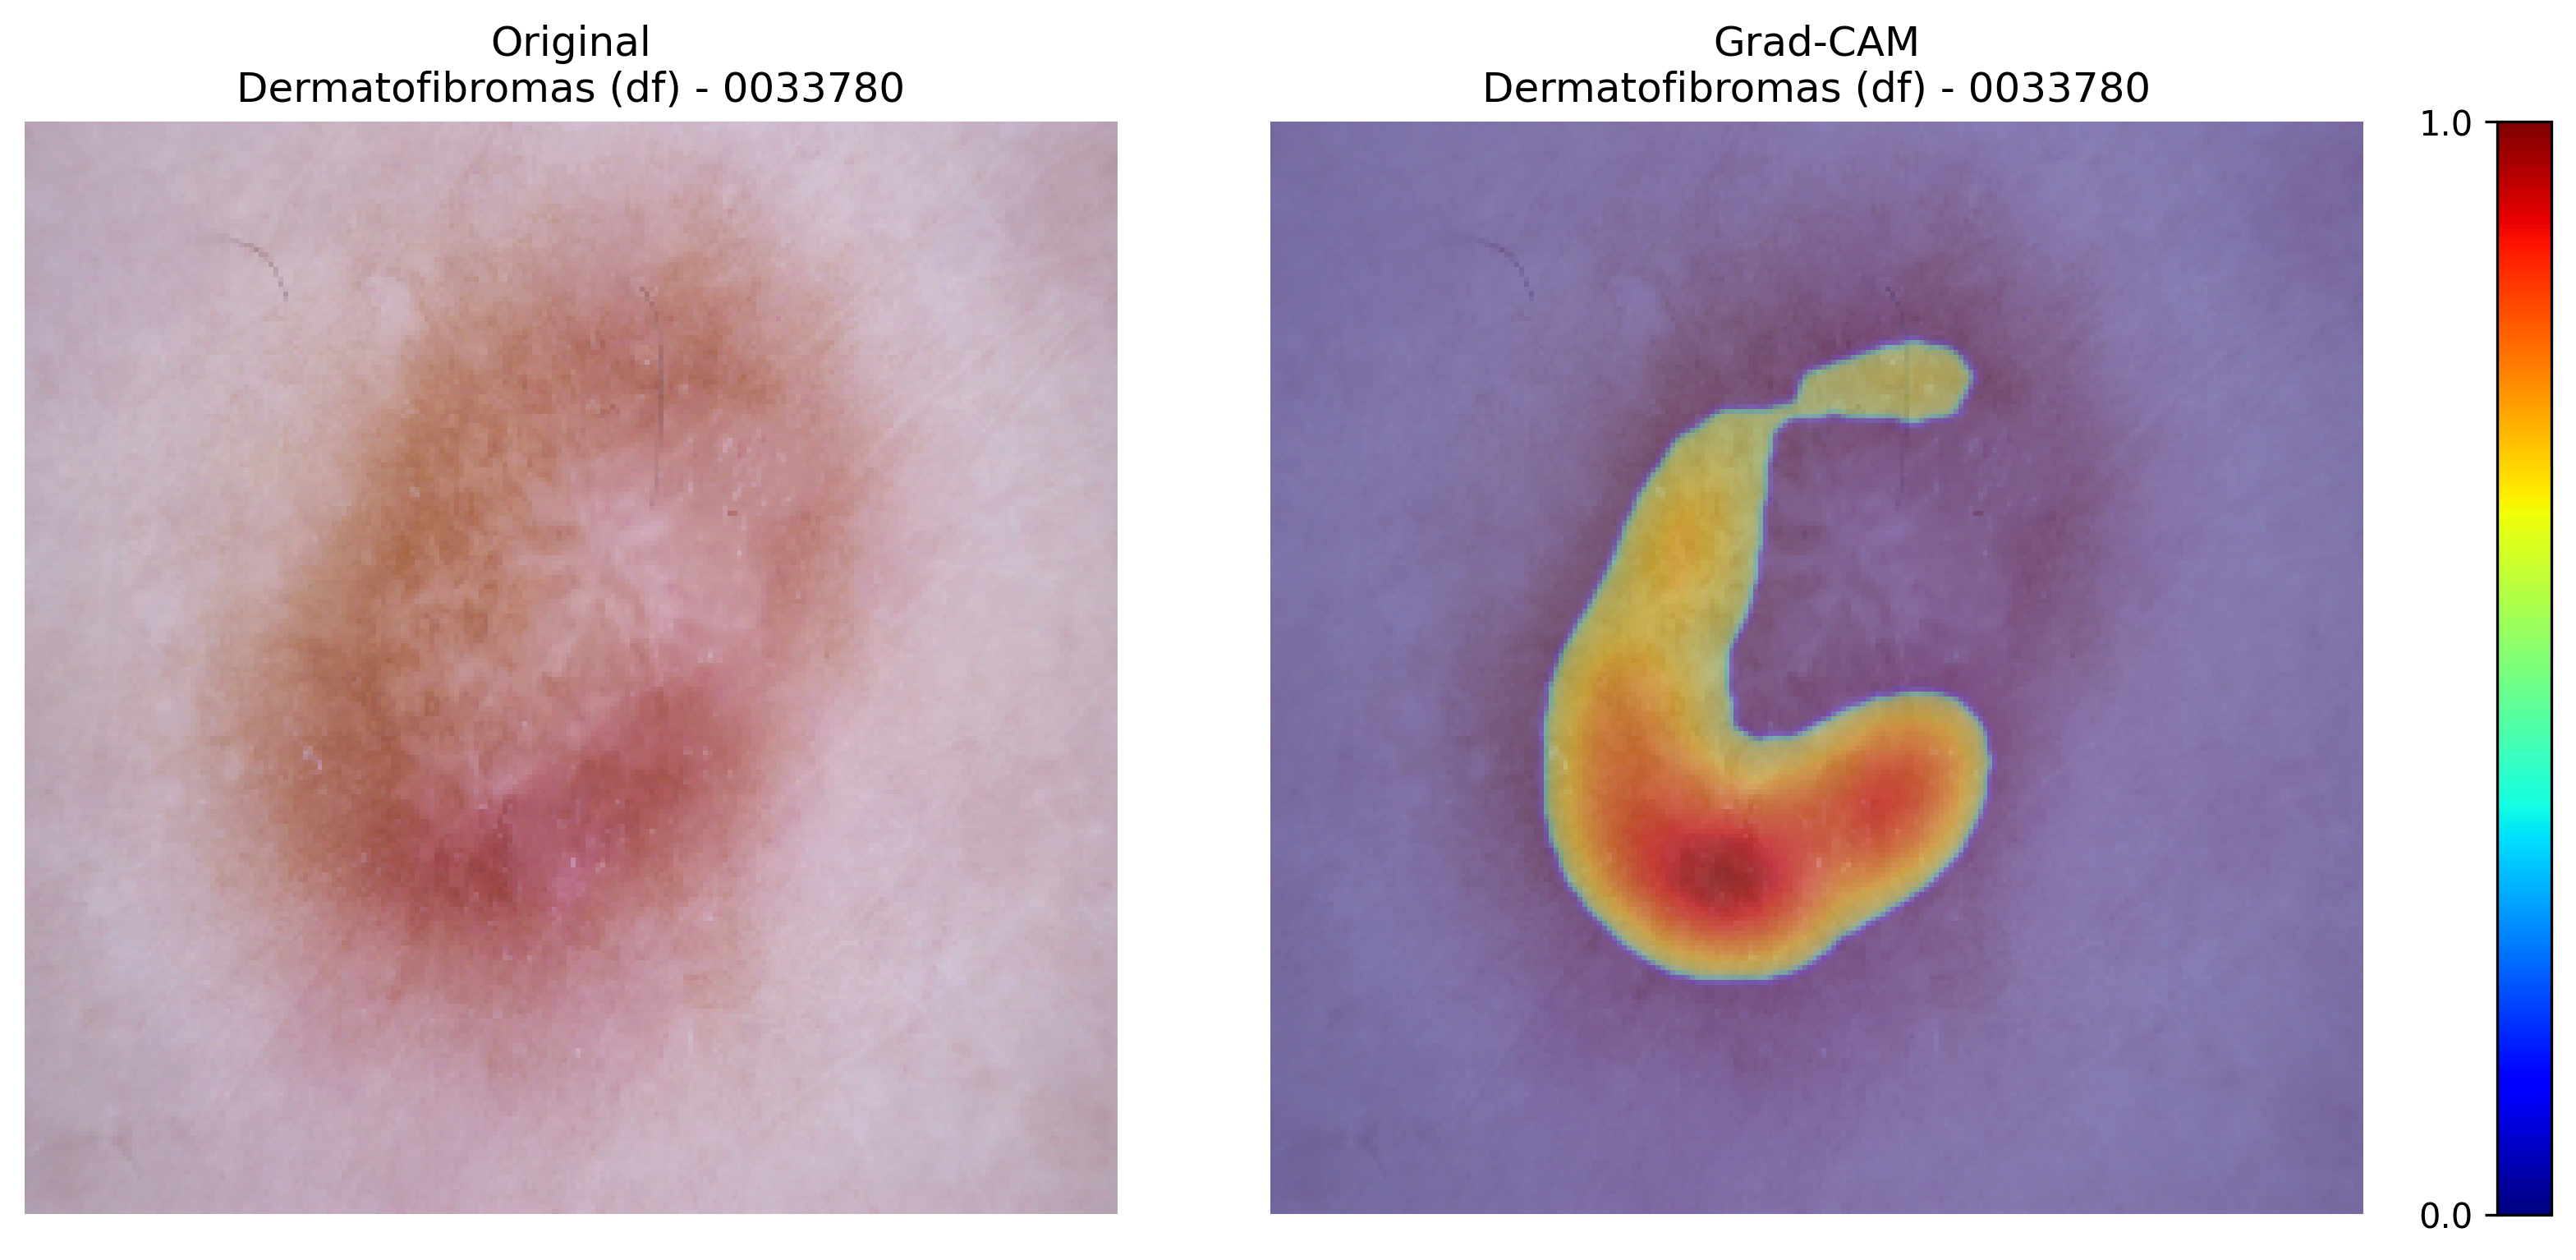

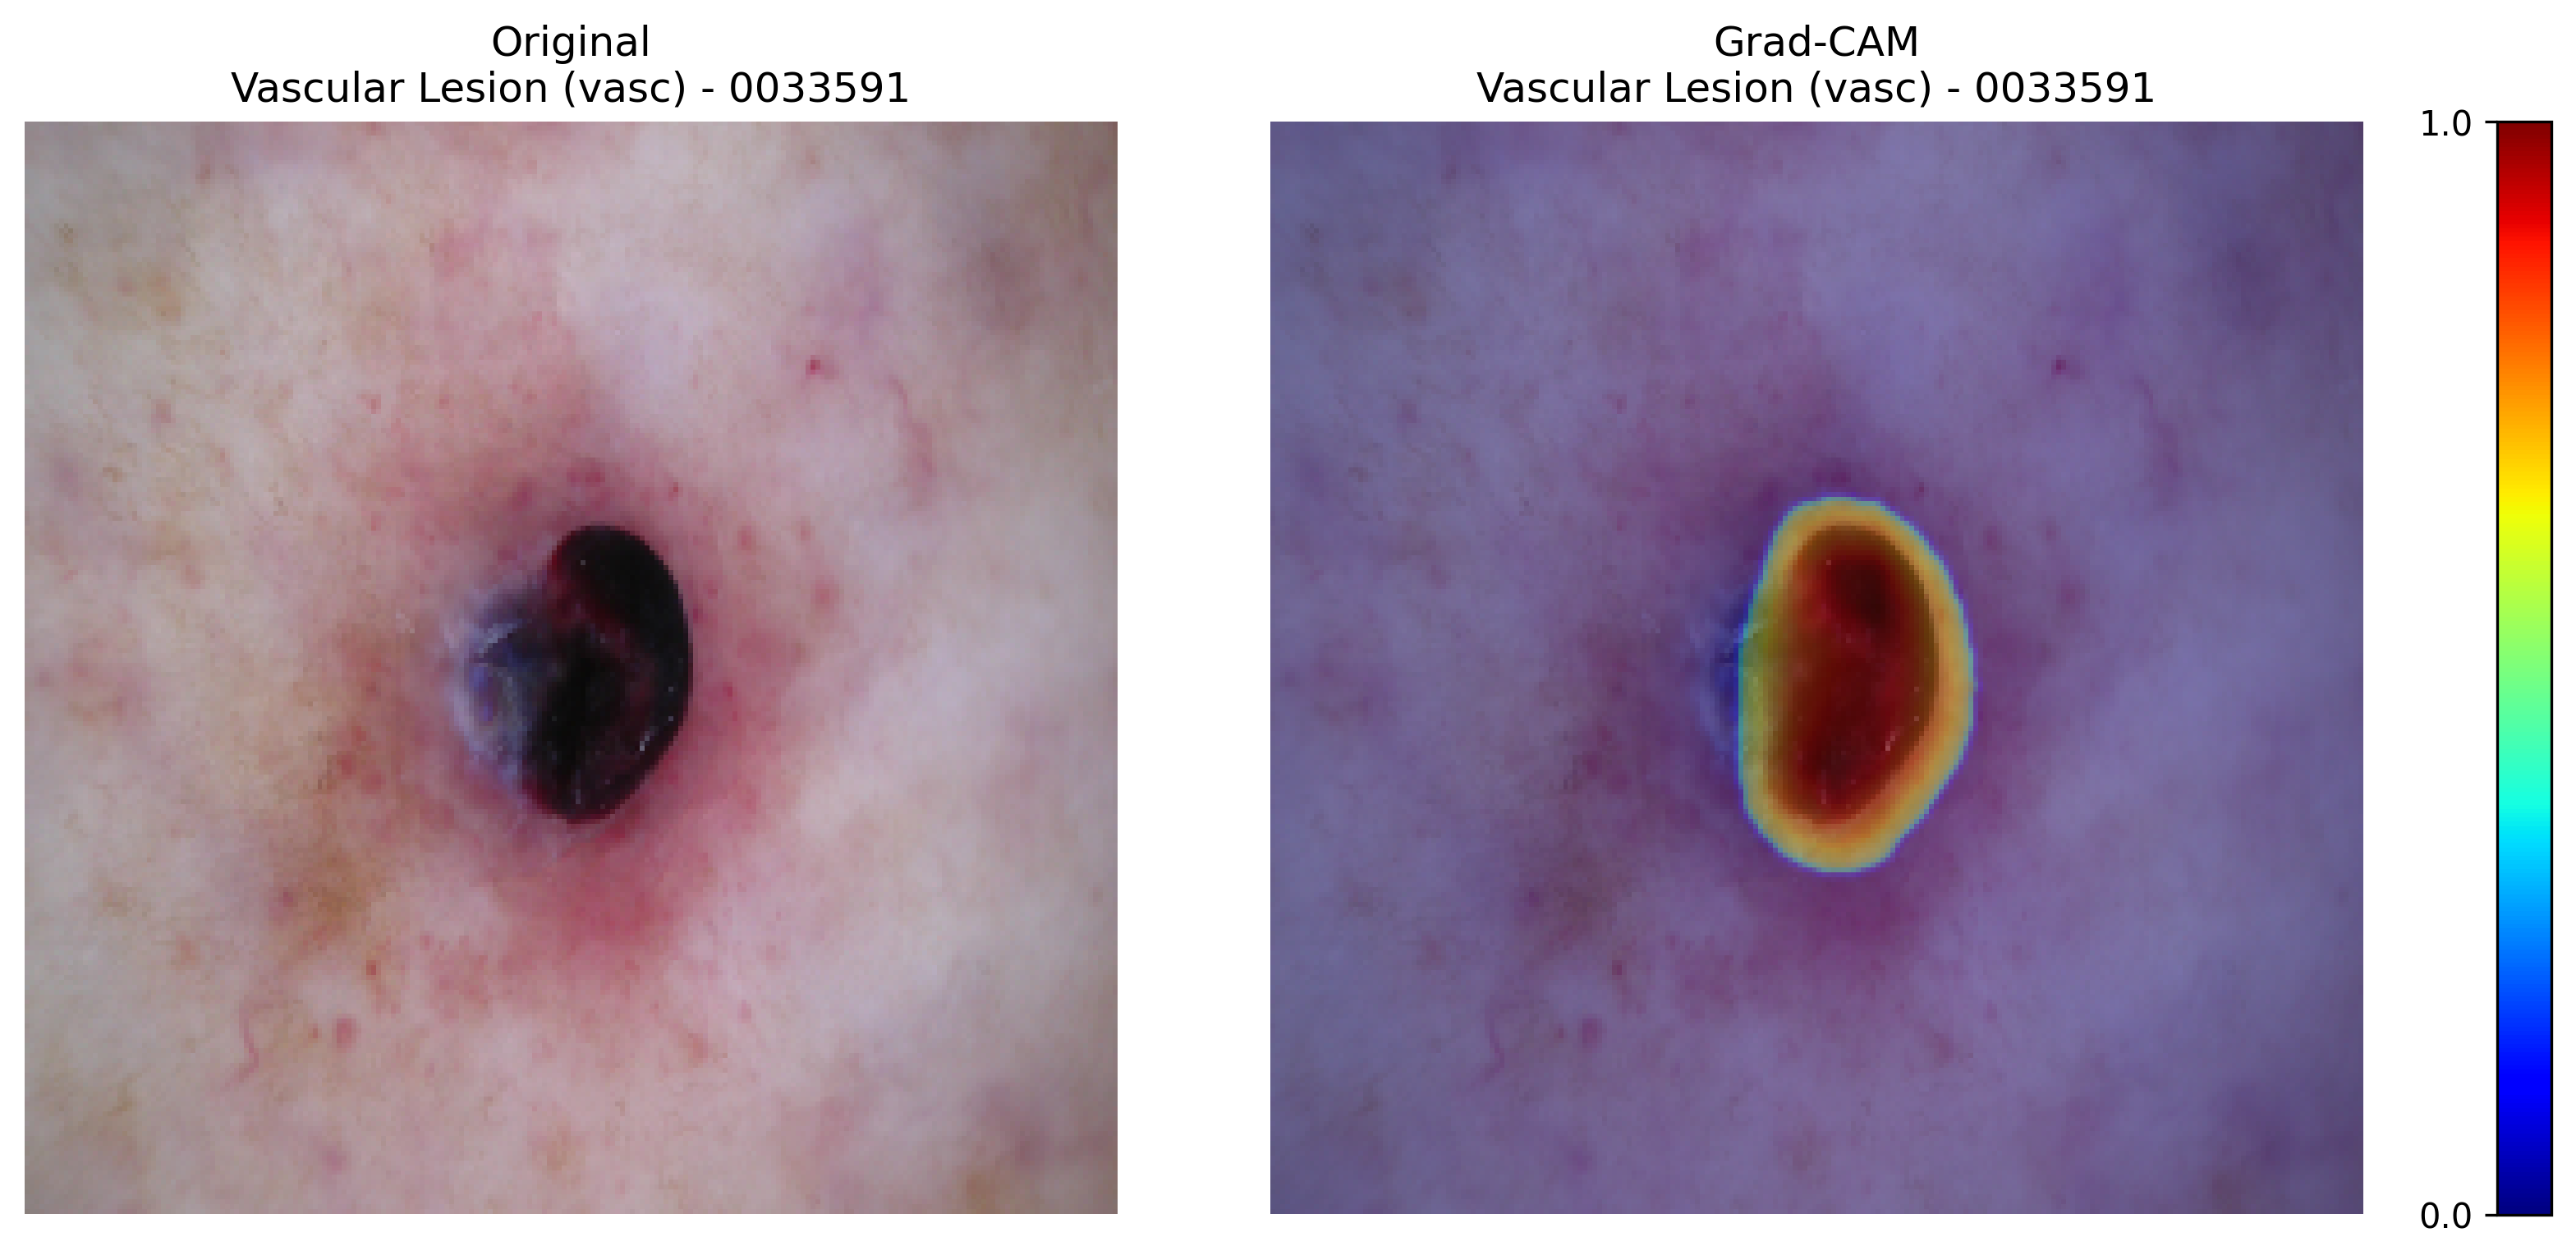

In [ ]:
examples = [
    {'image_class': 'mel', 'image_id': 26516, 'lesion_type': 'Malignant Melanoma'},
    {'image_class': 'nv', 'image_id': 31731, 'lesion_type': 'Benign Melanocytic Nevi'},
    {'image_class': 'df', 'image_id': 33780, 'lesion_type': 'Dermatofibromas (df)'},
    {'image_class': 'vasc', 'image_id': 33591, 'lesion_type': 'Vascular Lesion (vasc)'}
]

for img in examples:
    img_path = f"{data_dir}/test/{img['image_class']}/ISIC_00{img['image_id']}.jpg"
    grad_cam(img['image_id'], img_path, img['lesion_type'])